## Testdatencorpushersteller

GitHub Repository clonen und in GoogleColab anlegen

In [ ]:
!pwd

In [ ]:
!git clone https://github.com/edadunashvili/ThePrax.git

In [ ]:
cd ThePrax

In [ ]:
!pwd

#### !!! Ein Typ bestimmen !!!

In [63]:
typNum='300'
episode_string_train = "a300_string_train.csv"
episode_roh_train = "a300_roh_train.csv"

Vorhandener gleichnamiger Korpus wird gelöscht

In [64]:
import os
if os.path.exists(episode_string_train):
    os.remove(episode_string_train)
else:
    print("Diese Datei existiert nicht")

Im Ordner "Trainingsdaten" nach den entsprechenden Textdateien suchen und in einer rohe Datei zusammentragen

In [65]:
import glob

def word_to_lex(word):
    ret=(word) 
    return ret

def write_back(words):
    with open(episode_roh_train,"a", encoding='utf-8') as output:
        for word in words:
            #print(word)
            as_lex = word_to_lex(word[0])
            full_word = '"' + as_lex + '"'
            for sub_word in word[1:]:
                full_word += " , "  '"' + sub_word + '"'
            full_word +="\n"
            output.write(full_word)

def clean(line):
    line = line.replace("\n"," ").strip().lower()
    line = line.replace("ä","ae").replace("ü","ue").replace("ö","oe").replace("ß","ss").replace(",","").replace("«","")
    line = line.replace("»","").replace(".","").replace(":","").replace(";","").replace('"',"")
    line = line.replace("?","").replace("!","").replace("á","a").replace(",","").replace("\t"," ").replace("'","")
    line = line.replace("‹","").replace("›","").replace("-"," ").replace("'('","").replace("')'","").replace('>','')
    line = line.replace("    "," ").replace("   "," ").replace("  "," ").replace('–','').replace('—','').replace('<','')
    line = line.replace("Â", "A").replace("ø", "oe").replace('“','').replace('„','').replace('(','').replace(')','')
    line = line.replace("‚", "").replace(']','').replace('[','')
    if line == "": 
        return
    
    line=line.split("|")
    line[0]=line[0].split("|")[0]
    flex=[]
    try:
        flex=line[1].split("")
    except:
        pass
    value=str(line)
    line=str(line)   
    flex.append(line)
    ret=[]
    for i in flex:
        ret.append((i,value[0]))
    return ret

with open(episode_roh_train, "w", encoding='utf-8') as output:
    output.write ("quelle,episode,index_string,index_binar\n")
pairs = []

for file in glob.glob("Trainingsdaten/*.txt"):
    if typNum in file:
        with open(file, 'r', encoding='utf-8') as episode:
            for line in episode.readlines():
                clean_words = clean(line)
                pairs = pairs + clean_words
write_back(pairs)

Rohdatei endgültig überarbeiten und in eine CSV Datei speichern

In [66]:
fin = open(episode_roh_train,'r', encoding ='utf-8')
fout = open(episode_string_train, "wt", encoding ='utf-8')
for kfz in fin:
    fout.write(kfz.replace(', "["',"").replace('"[', "").replace(']"',"").replace("', '", "','").replace(" '", "'"))                      
fin.close()
fout.close()

Liste von einmaligen Episoden aus der CSV Datei zeigen

In [67]:
import pandas as pd
df = pd.read_csv(episode_string_train, encoding='utf-8')
from collections import Counter
indexliste=Counter(df.index_string)
print(*indexliste, sep='\n')

'e301_a_'
'e300_c_anfangssituation_ankunft_und_erkundigung_der_not'
'e300_e_vorfeld_des_kampfes_bis_zum_sieg'
'e300_i_rueckkehr_der_koenigstochter_und_die_suche_nach_dem_held retter'
'e300_o_auftritt_des_helden_vor_dem_koenig_bis_zum_ende_der_geschichte'
'e554_a_'
'eamom_a_'
'e516_a_'
'e513a_a_'
'e302_a_'
'e300_g_nach_dem_sieg_bis_zur_trennung_des_befreiers_und_der_befreiten'
'e300_k_misshandlung_des_falschen_helden_bis_zur_hochzeitstag'
'e328_a_'
'ecom_a_'
'eundf_a_'
'e300_m_rueckkehr_des_helden_ _von_der_erkundung_ueber_die_hochzeit_bis_zum_wiedergewinn_der_aufmerksamkeit'
'e303_g_erstes_treffen_mit_der_hexen'
'e303_i_vom_erkundigung_der_not_bis_zum_aufbruch_des_helden_zur_hexe'
'e303_k_vom_afbruch_zur_hexe_bis_zur_ihren_ueberweltigung'
'e303_c_eingangssituation_bis_zur_trennung'
'e314_a_'
'e850_a_'
'e303_m_eifersucht'
'e315_a_'
'e303_q_rueckkehr_und_finale'
'e303_o_erloesung_der_hexe'
'e567_a_'
'e562_a_'
'e550_a_'
'e590_a_'


Liste von allen Episoden aus der CSV Datei zeigen

In [18]:
#import pandas as pd
#df = pd.read_csv(episode_string_train, encoding='utf-8')
#x='_'
#for gesep in (df.index_string):
    #if x in gesep:
        #print(gesep) 

## Auswerter

#### !!! Elementenstruktur definieren: vorherige Episode - gesuchte Episode - folgende Episode !!!

In [68]:
import pandas as pd
df = pd.read_csv('a300_string_train.csv', encoding='utf-8')
from collections import Counter

def ep_format(ep_full):
    return (ep_full.split('_'))[0]

def quellenvergleich (df, i1, i2):
#     print(df.quelle[i1],df.quelle[i2])
    return df.quelle[i1]==df.quelle[i2]

def ast(gesep, df):
    ep_tree = {}
    a_liste = []
    z_liste = []  
    df_len = len(df.index_string)
    for i, ep in enumerate(df.index_string):
        if gesep == ep:
             #print(i, ep_full)
            if (i > 0)&(quellenvergleich(df, i, i-1)):
                a = df.index_string[i-1]
            else:
                a = 'eAnfang_a_'
            if (i < df_len - 1):
                if not (quellenvergleich(df, i, i+1)):
                    z = 'eEnde_a_'
                else:        
                    z = df.index_string[i+1]
            else:
                z = 'eEnde_a_'
            a_liste.append(a)
            z_liste.append(z)
    return {gesep: [Counter(a_liste), Counter(z_liste)]}

Alle im Korpus vorhandene Episoden extrahieren

In [69]:
def alle_aeste(gesep, df):
    episoden_baeume = {}
    
    ep_list = []
    for ep_full in df.index_string:  
        
        ep = ep_format(ep_full)      
        if gesep == ep:          
            
            ep_list.append(ep_full)
    for ep in set(ep_list):
        episoden_baeume.update(ast(ep,df))
    return episoden_baeume

Episoden die gesuchte Episode umlegen und in die Liste in die richrige Reihenfolge darstellen

In [70]:
def key_val_printer(d):
    for k, v in d.items():
        print(v, k, sep=':')
    #print()
        
def baum_printer(baeume: dict, baum: str):
    key_val_printer (baeume[baum][0])
    
    
    print(80*'-')
    print(sum(baeume[baum][0].values()), baum)
    print(80*'-')
    key_val_printer(baeume[baum][1]) 
    
            
def wald_printer(wald: dict):
    for baum in sorted(wald.keys()):
        baum_printer (wald, baum)
        print('\n',80*'=','\n')

#### !!! Die gesuchte Episode bestimmen !!!

In [72]:
synop = alle_aeste("'e300", df)
wald_printer(synop)

2:'e301_a_'
1:'e302_a_'
8:'e554_a_'
1:eAnfang_a_
1:'e314_a_'
4:'e315_a_'
7:'e303_c_eingangssituation_bis_zur_trennung'
4:'eundf_a_'
1:'e300_o_auftritt_des_helden_vor_dem_koenig_bis_zum_ende_der_geschichte'
1:'e300_c_anfangssituation_ankunft_und_erkundigung_der_not'
1:'e303_i_vom_erkundigung_der_not_bis_zum_aufbruch_des_helden_zur_hexe'
1:'e550_a_'
2:'e562_a_'
1:'e590_a_'
1:'e300_e_vorfeld_des_kampfes_bis_zum_sieg'
--------------------------------------------------------------------------------
36 'e300_c_anfangssituation_ankunft_und_erkundigung_der_not'
--------------------------------------------------------------------------------
34:'e300_e_vorfeld_des_kampfes_bis_zum_sieg'
1:eEnde_a_
1:'e300_c_anfangssituation_ankunft_und_erkundigung_der_not'


34:'e300_c_anfangssituation_ankunft_und_erkundigung_der_not'
2:'e300_k_misshandlung_des_falschen_helden_bis_zur_hochzeitstag'
1:'e315_a_'
1:'e550_a_'
2:'eundf_a_'
1:'e562_a_'
------------------------------------------------------------------

## Automatische Analyse

In [1]:
import keras
import glob
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pyprind
import pandas as pd
import random
import re
import string
from collections import Counter
from nltk.corpus import stopwords
from keras import backend as K
from keras import layers
from keras import losses
from keras import models
from keras import metrics
from keras import optimizers
from keras.preprocessing import sequence

Using TensorFlow backend.


#### !!! Variable anpassen !!!

In [74]:
ziel_episode = 'e300_c_anfangssituation_ankunft_und_erkundigung_der_not'
mini_frequenz = 2
k_fach = 5
layD = 96
episode_string_train = 'a300_string_train.csv' 
episode_binar_train = 'a300_binar_train.csv'
episode_string_mess = 'gesamt_string_mess.csv'
episode_binar_mess = 'gesamt_binar_mess.csv'

Aufbereitung der Trainingsdaten
Rohdaten laden und und den Episodenbestand betrachten

In [75]:
fin = open(episode_string_train,'r', encoding='utf-8') 
fout = open(episode_binar_train, "wt", encoding='utf-8')
for efz in fin:
    fout.write(efz.replace("'",""))  
fin.close()
fout.close()

In [76]:
df = pd.read_csv(episode_binar_train, encoding='utf-8')
indexliste=Counter(df.index_string)
print(indexliste, sep='\n')

Counter({'e300_e_vorfeld_des_kampfes_bis_zum_sieg': 41, 'e300_c_anfangssituation_ankunft_und_erkundigung_der_not': 36, 'e300_o_auftritt_des_helden_vor_dem_koenig_bis_zum_ende_der_geschichte': 34, 'e300_g_nach_dem_sieg_bis_zur_trennung_des_befreiers_und_der_befreiten': 30, 'e554_a_': 28, 'e300_k_misshandlung_des_falschen_helden_bis_zur_hochzeitstag': 28, 'e300_m_rueckkehr_des_helden_ _von_der_erkundung_ueber_die_hochzeit_bis_zum_wiedergewinn_der_aufmerksamkeit': 19, 'e303_g_erstes_treffen_mit_der_hexen': 16, 'e303_c_eingangssituation_bis_zur_trennung': 16, 'e303_i_vom_erkundigung_der_not_bis_zum_aufbruch_des_helden_zur_hexe': 15, 'e303_k_vom_afbruch_zur_hexe_bis_zur_ihren_ueberweltigung': 15, 'eundf_a_': 13, 'e315_a_': 12, 'ecom_a_': 11, 'e301_a_': 7, 'e300_i_rueckkehr_der_koenigstochter_und_die_suche_nach_dem_held retter': 7, 'e550_a_': 7, 'e562_a_': 6, 'e303_m_eifersucht': 5, 'e328_a_': 4, 'e303_q_rueckkehr_und_finale': 4, 'e567_a_': 3, 'e516_a_': 2, 'e513a_a_': 2, 'e302_a_': 2, 'eamo

Die gesuchte Episode etikettieren und den Rohdaten in Trainingsdaten umwandeln

In [77]:
for i,e in enumerate(df.index_string):
    if e == ziel_episode:
        df.index_binar[i]='1'
    else: 
        df.index_binar[i]='0'

In [78]:
df.to_csv(episode_binar_train, encoding='utf-8', index=False)

Trainngsdaten aufbereiten
4.1. Das Vorkommen jedes Wortes zählen

In [79]:
nltk.download('stopwords')
w = stopwords.words('german')
counts = Counter()
pbar = pyprind.ProgBar(len(df['episode']),
                       title='Vorkommen der Wörter zählen')
for i, episode in enumerate(df['episode']): 
        pbar.update()
        counts.update(episode.split())
new_counts = {}
for k, v in counts.items():
    if v > mini_frequenz and k not in w:
        new_counts[k] = v
counts = Counter(new_counts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elguj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
Vorkommen der Wörter zählen
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Zuordnung erzeugen und den verschiedenen Wörtern eindeutige Zahlen zuordnen

In [80]:
word_counts = sorted(counts, key=counts.get, reverse=True)
word_to_int = {word: ii for ii, word in enumerate(word_counts,0)}
mapped_episoden = []
pbar = pyprind.ProgBar(len(df['episode']),
                       title='Episoden Zahlen zuordnen')
for episode in df['episode']:
    mapped_episoden.append([word_to_int.get(word) for word in episode.split()])
    pbar.update()
mapped_episoden = [list(filter(None, el)) for el in mapped_episoden]

Episoden Zahlen zuordnen
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Traiingsndaten und Trainingslabels bestimmen

In [81]:
train_data = mapped_episoden[0:] 
train_labels = df.loc[0:, 'index_binar'].values
print("sequences =",max([max(sequences) for sequences in mapped_episoden if len(sequences)>0])," ",
      "train_data =", len (train_data))

sequences = 2593   train_data = 368


Trainingsdaten und -Labels vektorisieren

In [82]:
sequences_laenge=max([max(sequences) for sequences in mapped_episoden if len(sequences)>0])
def vectorize_sequences(sequences, dimension=sequences_laenge+1): 
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data) 
y_train = np.asarray(train_labels).astype('float32')

In [83]:
#for i, element in enumerate(x_train[63]):
    #print(i,'-', element)

Neuronales Netz erzeugen

In [84]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(layD, activation='tanh',
                           input_shape=(sequences_laenge+1,)))
    #model.add(layers.Dense(layD, activation='relu'))
    model.add(layers.Dense(layD, activation='tanh')) 
    model.add(layers.Dense((1), activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['binary_accuracy'])
    return model

Neuronales Netz trainieren

In [85]:
k = k_fach
num_val_samples = len(x_train) // k 
num_epochs = 4
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_x_train, partial_y_train,
              epochs=num_epochs, batch_size = 8, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_binary_accuracy = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_binary_accuracy)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [86]:
all_scores

[0.958904109589041,
 0.958904109589041,
 0.9726027397260274,
 0.9863013698630136,
 0.9041095890410958]

In [87]:
np.mean(all_scores)

0.9561643835616438

In [88]:
num_epochs = 8
all_binary_accuracy_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size = 8, verbose=0)
    binary_accuracy_history = history.history['val_binary_accuracy']
    all_binary_accuracy_histories.append(binary_accuracy_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [89]:
average_binary_accuracy_history = [
    np.mean([x[i] for x in all_binary_accuracy_histories]) for i in range(num_epochs)]
for i, element in enumerate(average_binary_accuracy_history):
    print(i,'-', element)

0 - 0.9342465753424657
1 - 0.9616438356164384
2 - 0.958904109589041
3 - 0.9561643835616438
4 - 0.9506849315068493
5 - 0.9479452054794519
6 - 0.9506849315068493
7 - 0.9506849315068493


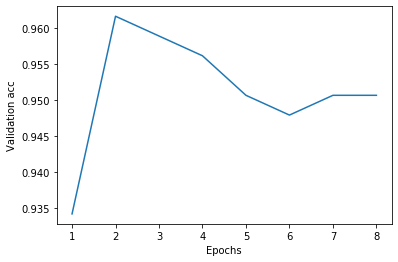

In [90]:
plt.plot(range(1, len(average_binary_accuracy_history) + 1), average_binary_accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Validation acc')
plt.show()

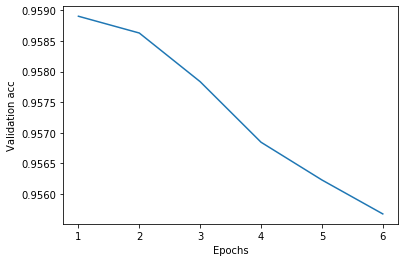

In [91]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_binary_accuracy_history = smooth_curve(average_binary_accuracy_history[2:])

plt.plot(range(1, len(smooth_binary_accuracy_history) + 1), smooth_binary_accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Validation acc')
plt.show()

### Messdaten erstellen

#### !!! Ein Typ bestimmen !!!

In [92]:
typNum =''
episode_string_train = "gesamt_string_mess.csv"
episode_roh_train = "gesamt_roh_mess.csv"

Alte Datei mit gleichem Namen löschen

In [93]:
import os
if os.path.exists(episode_string_train):
    os.remove(episode_string_train)
else:
    print("Diese Datei existiert nicht")

Nach den entsprechenden Textdateien im Ordnet suchen und in einer rohe Datei zusammentragen

In [94]:
import glob

def word_to_lex(word):
    ret=(word) 
    return ret

def write_back(words):
    with open(episode_roh_train,"a", encoding='utf-8') as output:
        for word in words:
            #print(word)
            as_lex = word_to_lex(word[0])
            full_word = '"' + as_lex + '"'
            for sub_word in word[1:]:
                full_word += " , "  '"' + sub_word + '"'
            full_word +="\n"
            output.write(full_word)

def clean(line):
    line = line.replace("\n"," ").strip().lower()
    line = line.replace("ä","ae").replace("ü","ue").replace("ö","oe").replace("ß","ss").replace(",","").replace("«","")
    line = line.replace("»","").replace(".","").replace(":","").replace(";","").replace('"',"")
    line = line.replace("?","").replace("!","").replace("á","a").replace(",","").replace("\t"," ").replace("'","")
    line = line.replace("‹","").replace("›","").replace("-"," ").replace("'('","").replace("')'","").replace('>','')
    line = line.replace("    "," ").replace("   "," ").replace("  "," ").replace('–','').replace('—','').replace('<','')
    line = line.replace("Â", "A").replace("ø", "oe").replace('“','').replace('„','').replace('(','').replace(')','')
    line = line.replace("‚", "").replace(']','').replace('[','')
    if line == "": 
        return
    
    line=line.split("|")
    line[0]=line[0].split("|")[0]
    flex=[]
    try:
        flex=line[1].split("")
    except:
        pass
    value=str(line)
    line=str(line)   
    flex.append(line)
    ret=[]
    for i in flex:
        ret.append((i,value[0]))
    return ret

with open(episode_roh_train, "w", encoding='utf-8') as output:
    output.write ("quelle,episode,index_string,index_binar\n")
pairs = []

for file in glob.glob("Messdaten/*.txt"):
    if typNum in file:
        with open(file, 'r', encoding='utf-8') as episode:
            for line in episode.readlines():
                clean_words = clean(line)
                pairs = pairs + clean_words
write_back(pairs)

Rohdatei endgültig überarbeiten und in eine CSV Datei speichern

In [95]:
fin = open(episode_roh_train,'r', encoding ='utf-8')
fout = open(episode_string_train, "wt", encoding ='utf-8')
for kfz in fin:
    fout.write(kfz.replace(', "["',"").replace('"[', "").replace(']"',"").replace("', '", "','").replace(" '", "'"))                      
fin.close()
fout.close()

Liste von einmaligen Episoden erstellen in der CSV Datei

In [96]:
import pandas as pd
df = pd.read_csv(episode_string_train, encoding='utf-8')
from collections import Counter
indexliste=Counter(df.index_string)
print(*indexliste, sep='\n')

'0'


Messdaten laden und aufbereiten

In [97]:
fin = open(episode_string_mess,'r', encoding='utf-8') 
fout = open(episode_binar_mess, "wt", encoding='utf-8')
for efz in fin:
    fout.write(efz.replace("'",""))
                                 
fin.close()
fout.close()

In [98]:
df = pd.read_csv(episode_binar_mess, encoding='utf-8')
indexliste=Counter(df.index_string)
print(indexliste, sep='\n')

Counter({0: 147})


In [99]:
for i,e in enumerate(df.index_string):
    if e:
        df.index_binar[i]='0'
    else: 
        df.index_binar[i]='0'

C:\Users\elguj\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [100]:
df.to_csv(episode_binar_mess, encoding='utf-8', index=False)

Vorhandene Zuordnung laden und den verschiedenen Wörtern eindeutige Zahlen zuordnen

In [101]:
mapped_episoden_2 = []
pbar = pyprind.ProgBar(len(df['episode']),
                       title='Episoden Zahlen zuordnen')
for episode in df['episode']:
    mapped_episoden_2.append([word_to_int.get(word) for word in episode.split()])
    pbar.update()

mapped_episoden_2 = [list(filter(None, el)) for el in mapped_episoden_2]


Episoden Zahlen zuordnen
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


raiingsndaten und Trainingslabels bestimmen

In [102]:
mess_data = mapped_episoden_2[0:] 
mess_labels = df.loc[0:, 'index_binar'].values
print("sequences =",max([max(sequences) for sequences in mapped_episoden if len(sequences)>0])," ", 
      "mess_data =", len (mess_data))

sequences = 2593   mess_data = 147


Messdaten vektorisieren

In [103]:
def vectorize_sequences(sequences, dimension=sequences_laenge+1): 
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_mess = vectorize_sequences(mess_data)
y_mess = np.asarray(mess_labels).astype('float32')

Messdaten Analysieren

In [104]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(x_train, y_train,
          epochs = 2, batch_size = 1)
mess_mse_score, mess_binary_accuracy_score = model.evaluate(x_mess, y_mess)

Epoch 1/2
368/368 [==============================] - 3s 7ms/step - loss: 0.0801 - binary_accuracy: 0.9158
Epoch 2/2
147/147 [==============================] - 0s 2ms/step


In [105]:
mess_binary_accuracy_score, mess_mse_score

(0.9659863945578231, 0.037964944155578606)

Voraussagen

In [106]:
predictions=model.predict(x_mess)
#for i in range(len(predictions)):
    #print(model.predict(x_mess))

In [107]:
print('Maximaler Wert:', max(max(model.predict(x_mess))))

Maximaler Wert: 0.999997


Voraussgen in den aussortierten Datensätzen

In [109]:
mod_pred = model.predict(x_mess)
cutoff_value = 0.6
for i in range(len(y_mess)):
    if mod_pred[i,0]>cutoff_value:
        if ((i==0)|(mod_pred[i-1,0]>cutoff_value))|(mod_pred[i+0]>cutoff_value):
            #if df.index_string ==0:
                print (i+0,"-",
                  #i+2,"-", 
                  #y_test[i],"-", 
                  mod_pred[i],"-",
                  df.quelle[i+0],"-", 
                  df.episode[i+0],"-",
                  df.index_string[i+0],'\n')

0 - [0.999997] - 0_e300c - kneten frass wasser gruetze dannen kurz frug abendessen demjenigen naehe retten darum dunkelwelt geselle toeten wirtshaus halten versuchen rede ass gefallen betruebt mensch seid einzige seien maedchen hurtigundgeschwind jedesmal gesellen verhaengt boeser krone brief drach geraubt nacheinander ueberzogen uhr fragt finde kind erste witwe fahnen geben bedeuten wirth meermanne geopfert fresse ausgeliefert muessen gleichen herberge gast uebrigen dach frassen muessten antwortete behangen bedingung haeuser toechtern unsres grossmutters jungfrau schoene geb reich damals drache alljaehrlich loos tochter wirt verschlang haeuschen schwarz koenigreichs grade flor naechste erloesen ach sei uebergeben schuster menschen befreien trauer fragte versprochen schwarzem traurig stadt warum reihe - 0 

34 - [0.98617995] - mess_46 -  ach mein kind wir haben hier kein wasser in dieser gegend hier lebt eine lamia die das wasser unter verschluss haelt wir bekommen nichts wenn sie nich

In [110]:
fobj = open ('Messdaten/mess_47.txt', 'r', encoding='utf-8')
for line in fobj:
    print (line.rstrip())

mess_47|Es war einmal ein Schneider, klein von Gestalt, der auf der Welt in der Fremde herumwanderte. Wie er eines Tages so dahin ging, kam er in einen Wald und in diesem zu einer Quelle, neben welcher er ein rothseidenes Band fand, auf dem die Worte standen: »Sieben auf einen Schlag, wer macht es mir nach.« Der Schneider hob es auf und band es sich um den Leib.|0|0
mess_47|[280] Da er schon lange weiter gewandert war, kam ihm plötzlich ein Riese entgegen, der ihn hart anfuhr und ihm fürchterlich drohte. Der Schneider aber gedachte seines Bandes und der Worte, die darauf standen, und machte sich nicht viel aus den Drohungen des Riesen. So zankend und streitend kamen sie zu einem Kirschenbaum, der voll reifer Kirschen hing. Da sagte der Riese höhnisch: »Halt, ich will dir die Aeste des Baumes herabbiegen, damit du von den Kirschen essen kannst. Laß es dir noch schmecken, denn wenn du gegessen hast, will ich dich umbringen.«|0|0
mess_47|Der Riese bog also den Baum hernieder, und der Schn